# Modelos de Clasificación sobre la base de datos Flights

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Regresión Logística Accuracy: 69.65%
              precision    recall  f1-score   support

           0       0.70      0.94      0.81     21074
           1       0.63      0.21      0.31     10516

    accuracy                           0.70     31590
   macro avg       0.67      0.57      0.56     31590
weighted avg       0.68      0.70      0.64     31590

Regresión Logística Kappa: 0.179


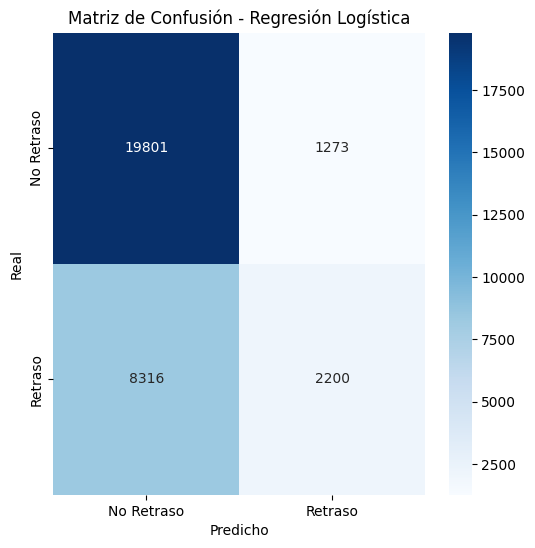

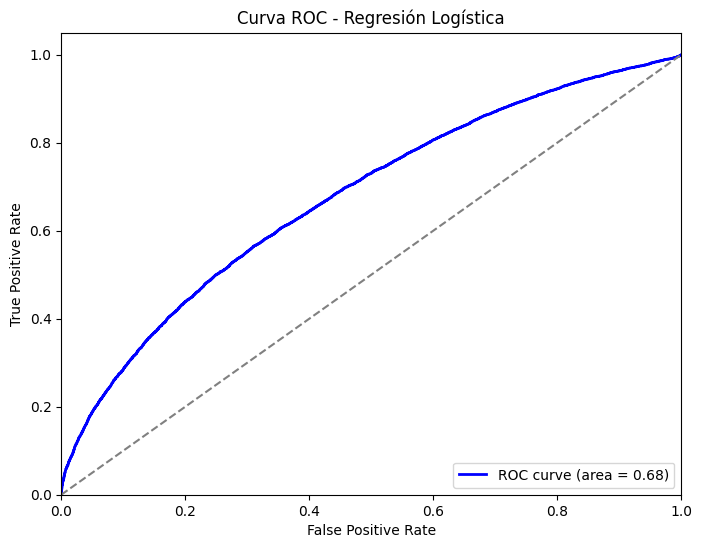


Random Forest Accuracy: 69.11%
              precision    recall  f1-score   support

           0       0.69      0.97      0.81     21074
           1       0.67      0.14      0.23     10516

    accuracy                           0.69     31590
   macro avg       0.68      0.55      0.52     31590
weighted avg       0.69      0.69      0.62     31590

Random Forest Kappa: 0.133


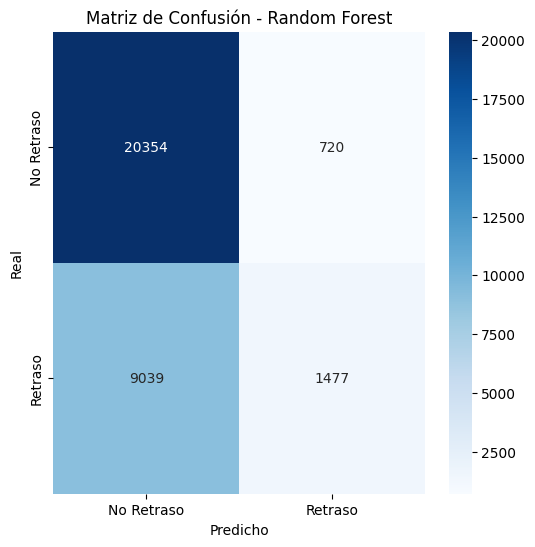

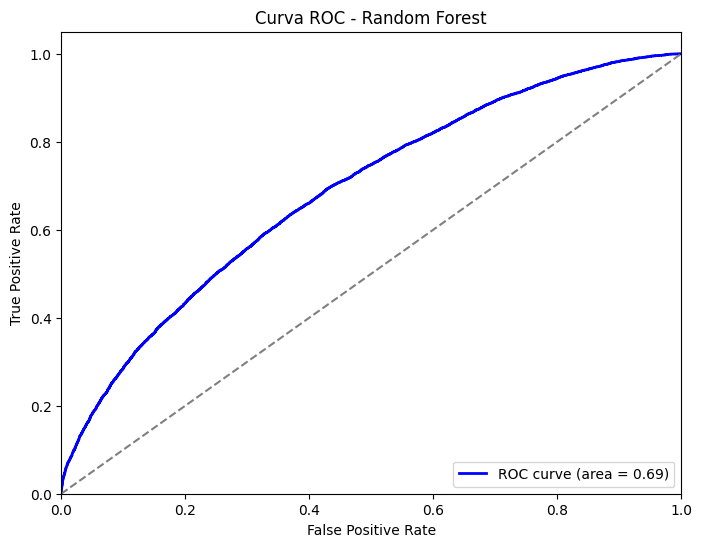


kNN Accuracy: 65.08%
              precision    recall  f1-score   support

           0       0.71      0.82      0.76     21074
           1       0.46      0.32      0.38     10516

    accuracy                           0.65     31590
   macro avg       0.58      0.57      0.57     31590
weighted avg       0.63      0.65      0.63     31590

kNN Kappa: 0.145


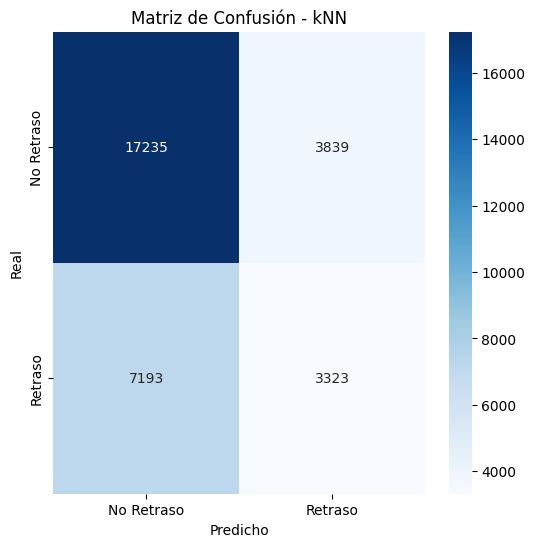

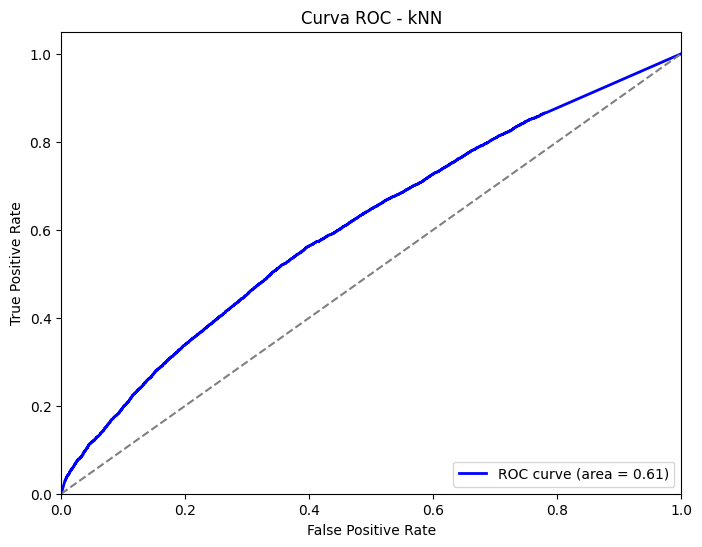


SVM (LinearSVC) Accuracy: 69.55%
              precision    recall  f1-score   support

           0       0.70      0.95      0.81     21074
           1       0.64      0.19      0.29     10516

    accuracy                           0.70     31590
   macro avg       0.67      0.57      0.55     31590
weighted avg       0.68      0.70      0.64     31590

SVM (LinearSVC) Kappa: 0.168


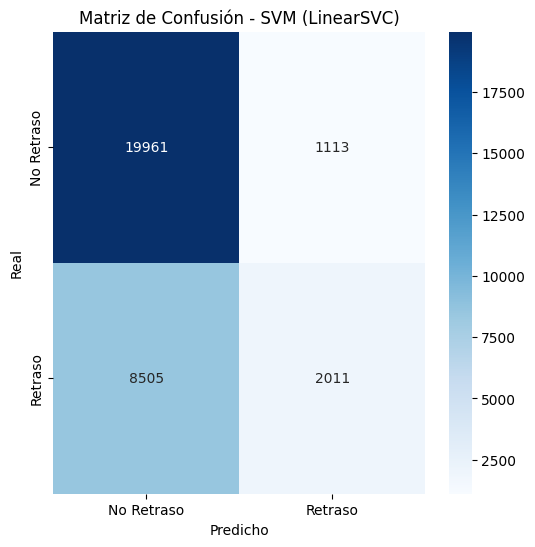

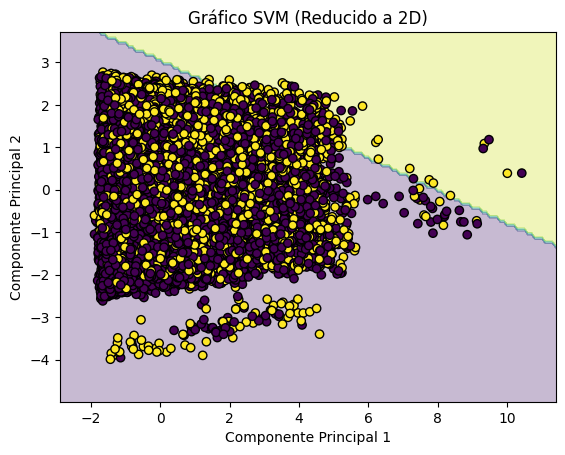

<ipython-input-4-62022ff6acdc>:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=features, palette='viridis')


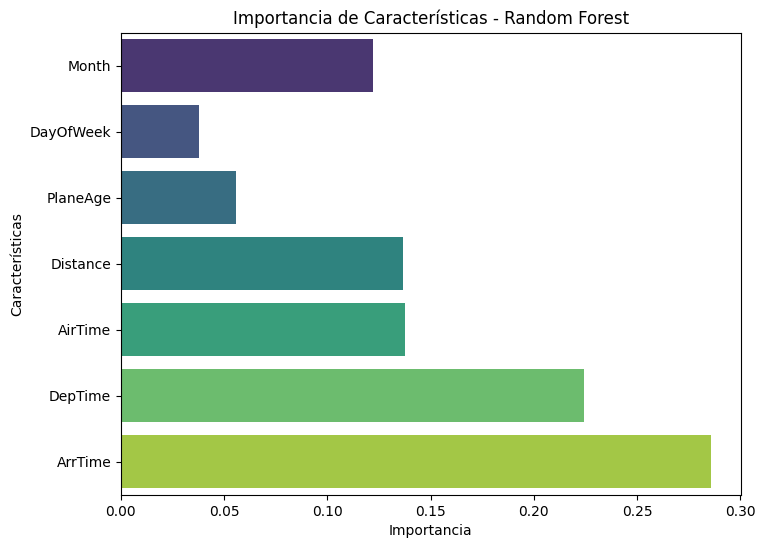

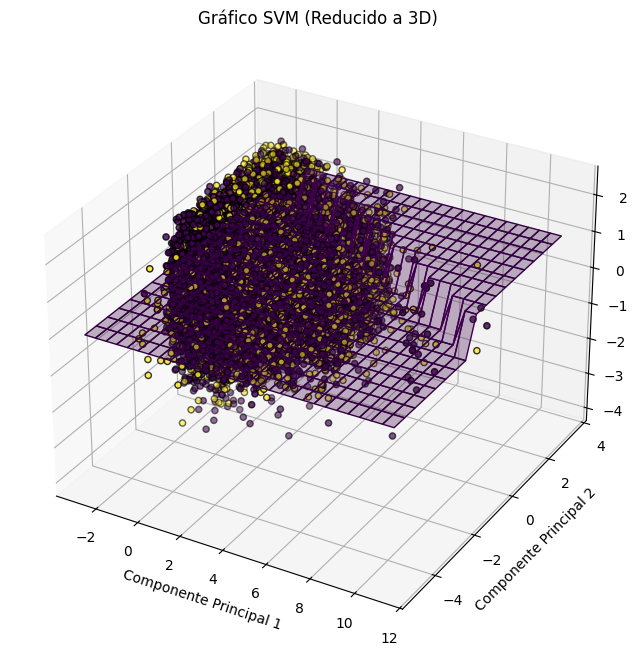

In [ ]:
# Carga de librerías y paquetes

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, cohen_kappa_score # Importamos cohen_kappa_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC  # Usando LinearSVC en lugar de SVC
import itertools
from sklearn.decomposition import PCA

# Montar Google Drive

from google.colab import drive
drive.mount('/content/drive')

# Ruta del archivo en Google Drive

ruta_archivo = '/content/drive/MyDrive/Obtención de datos/flights.csv'

# Carga de datos optimizada

chunk_size = 200000
sample_fraction = 0.016
cols_to_use = ["Month", "DayOfWeek", "PlaneAge", "Distance", "AirTime", "DepTime", "ArrTime", "ArrDelay"]

df_chunks = []
for chunk in pd.read_csv(ruta_archivo, usecols=cols_to_use, chunksize=chunk_size):
    chunk = chunk.dropna()
    sampled_chunk = chunk.sample(frac=sample_fraction, random_state=42)
    df_chunks.append(sampled_chunk)

df = pd.concat(df_chunks, ignore_index=True)
df = df.astype({col: 'float32' for col in df.select_dtypes(include=['float64', 'int64']).columns})

df["DepTime"] = 60 * np.floor(df["DepTime"] / 100) + np.mod(df["DepTime"], 100)
df["ArrTime"] = 60 * np.floor(df["ArrTime"] / 100) + np.mod(df["ArrTime"], 100)
df["Delayed"] = (df["ArrDelay"] > 5).astype(int)
df = df[(df["ArrDelay"] > -60) & (df["AirTime"] < 700)]

# Modelado de la base de datos

X = df[["Month", "DayOfWeek", "PlaneAge", "Distance", "AirTime", "DepTime", "ArrTime"]].to_numpy()
y = df["Delayed"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.333, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apartado gráfico de los modelos

# Función para visualizar la matriz de confusión

def plot_confusion_matrix(cm, classes, title='Matriz de Confusión'):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title(title)
    plt.show()

# Función para graficar la curva ROC

def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Definir el SVM como LinearSVC en lugar de SVC (más rápido para problemas lineales)

svm_model = LinearSVC(C=0.1, max_iter=1000, random_state=42)

models = {
    "Regresión Logística": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10, max_features='sqrt', random_state=42, n_jobs=-1),
    "kNN": KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1),
    "SVM (LinearSVC)": svm_model  # Usando LinearSVC
}

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{model_name} Accuracy: {accuracy_score(y_test, y_pred):.2%}")
    print(classification_report(y_test, y_pred))
    print(f"{model_name} Kappa: {cohen_kappa_score(y_test, y_pred):.3f}") # Calculo de kappa
    plot_confusion_matrix(cm, classes=['No Retraso', 'Retraso'], title=f'Matriz de Confusión - {model_name}')

    if hasattr(model, "predict_proba"):  # Modelos que soportan probabilidades
        y_score = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plot_roc_curve(fpr, tpr, roc_auc, model_name)

# Reducir la dimensionalidad a 2D usando PCA para la visualización

pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_scaled)

# Crear una malla para el gráfico

x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predecir los valores para la malla

Z = svm_model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

# Graficar los puntos de datos y la frontera de decisión

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='viridis', edgecolors='k')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Gráfico SVM (Reducido a 2D)')
plt.show()

# Importancia de características en Random Forest

rf = models["Random Forest"]
feature_importances = rf.feature_importances_
features = ["Month", "DayOfWeek", "PlaneAge", "Distance", "AirTime", "DepTime", "ArrTime"]

plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances, y=features, palette='viridis')
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Importancia de Características - Random Forest")
plt.show()

# Reducir la dimensionalidad a 3D usando PCA para la visualización

pca = PCA(n_components=3)

# Cambiar a 3 componentes

X_test_pca = pca.fit_transform(X_test_scaled)

# Crear una malla para el gráfico 3D (solo para x e y)

x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1

# Ajustar el paso para la malla

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5),
                     np.arange(y_min, y_max, 0.5))

# Predecir los valores para la malla (usando xx e yy)

Z = svm_model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())]))

# Rellenar la tercera componente (z) con ceros para que coincida con la entrada del modelo

Z = Z.reshape(xx.shape)

# Graficar los puntos de datos y la frontera de decisión en 3D

fig = plt.figure(figsize=(10, 8))

# Crear un subplot 3D

ax = fig.add_subplot(111, projection='3d')

# Superficie de decisión

ax.plot_surface(xx, yy, Z, facecolors=plt.cm.viridis(Z), alpha=0.3)
ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2], c=y_test, cmap='viridis', edgecolors='k')  # Puntos de datos
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')

# Agregar etiqueta para z

ax.set_zlabel('Componente Principal 3')
ax.set_title('Gráfico SVM (Reducido a 3D)')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
